In [29]:
import string
import pandas as pd
import csv

import matplotlib.pyplot as plt
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import rdmolops

import ast
import re

import codecs
# from SmilesPE.spe2vec import *
# from SmilesPE.tokenizer import *

from tensorflow.keras.utils import to_categorical
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast
from SmilesPE.pretokenizer import atomwise_tokenizer
import codecs
from SmilesPE.tokenizer import *
from SmilesPE.spe2vec import *
from SmilesPE.pretokenizer import kmer_tokenizer

from rdkit.Chem import AllChem as Chem
# import deepsmiles
# import selfies as sf

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
df = pd.read_csv('../data/VEGF2_ChEMBL28-10980_pic50_noDuplicate_canSmiles_sln_deepSmiles_selfies_inchi.csv',sep=',')
df.head(3)

,canonical_smiles,value,sln,deep_smiles,selfies,inchi
0,Br.COc1cc(OC)cc(N(CCP(=O)(O)O)c2ccc3ncc(-c4cnn...,7.32,BrH,Br.COcccOC))ccNCCP=O)O)O))))ccccncc-ccnnC)c5))...,[Br].[C][O][C][=C][C][Branch1_1][Ring1][O][C][...,InChI=1S/C22H24N5O5P.BrH/c1-26-14-15(12-24-26)...
1,Brc1ccc(-c2nc3ccc(Nc4ccnc5ccccc45)cc3[nH]2)cc1,6.75,BrC[5]=CHCH=C(C[4]=NC[3]=CHCH=C(NHC[1]=CHCH=NC...,Brcccc-cnccccNcccncccccc%106)))))))))))cc6[nH]...,[Br][C][=C][C][=C][Branch2_1][Ring1][S][C][=N]...,InChI=1S/C22H15BrN4/c23-15-7-5-14(6-8-15)22-26...
2,Brc1ccc(-c2nc3ccc(Nc4ncnc5ccccc45)cc3[nH]2)cc1,6.42,BrC[5]=CHCH=C(C[4]=NC[3]=CHCH=C(NHC[1]=NCH=NC[...,Brcccc-cnccccNcncncccccc%106)))))))))))cc6[nH]...,[Br][C][=C][C][=C][Branch2_1][Ring1][S][C][=N]...,InChI=1S/C21H14BrN5/c22-14-7-5-13(6-8-14)20-26...


## Remove longer and shorter molecules
- I choose length range (25 - 90)

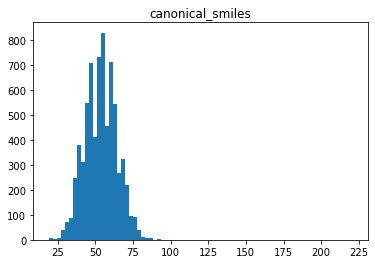

(7159, 11)
(7044, 11)


<Figure size 432x288 with 0 Axes>

In [31]:
linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']
plotHistogramCleanData(df['canonical_smiles'].str.len(),'canonical_smiles')
for notName in linearNotation_names:
    df[notName+'_length'] = df[notName].str.len()
print(df.shape)
# canonical_smiles_length
dfClean = df.loc[(df['canonical_smiles_length'] >30) & (df['canonical_smiles_length']<80)]
print(dfClean.shape)

### Histogramy delek pro chemicke linearni zapisy 

In [9]:
def plotHistogramCleanData(length_tokens,chem_notation):
    number_of_bins=len(set(length_tokens))
    plt.hist(length_tokens, bins = number_of_bins)
    plt.title(chem_notation)
    plt.show()
    plt.savefig('../data/histogramsLengthsSmiles/histogramLengthSmilesClean_'+chem_notation+'.png')
    return

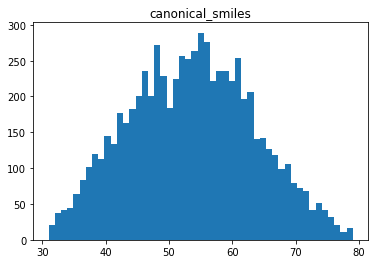

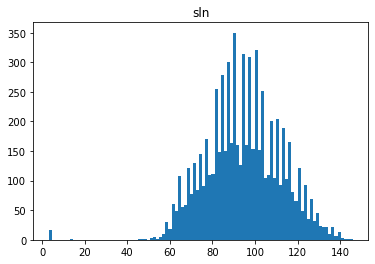

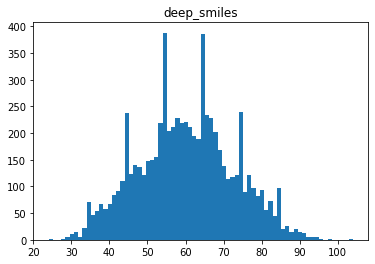

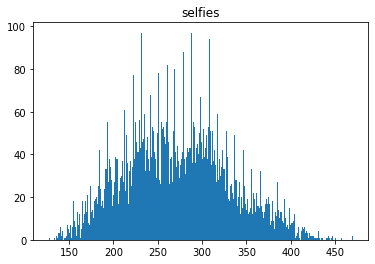

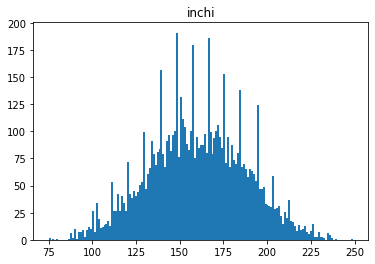

<Figure size 432x288 with 0 Axes>

In [10]:
linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']

for notName in linearNotation_names:
    plotHistogramCleanData(dfClean[notName].str.len(),notName)

### The right lengths of tokens
- provest tokenizaci 
- vykreslit histogramy pro pocty tokenu
- natrenovat ANN a vybrat nejlepsi pocty tokenu pro jednotlive chem lin zapisy jednotlivych tokenizaci

#### Tokenization

**Pomocne funkce**

In [12]:
def removeBeginningInChI(chem_notation,substring):
    res = chem_notation.replace(substring,'')
    return res

In [13]:
def splitByAtomwiseTokenizer(chem_notation):
    lst=[]
    temp = atomwise_tokenizer(chem_notation)
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [14]:
def addCharAtBeginningEnd(temp):
    lst=[]
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [15]:
def tokenizationBPEChemLinearNotaion(col_name,df):
    fileName = 'data_for_tokenizer/tokenizer-wiki_'+str(col_name)+'.json' 
    fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file=fileName)
    return df[col_name].apply(lambda chem_notaion: fast_tokenizer.tokenize(str(chem_notaion)))

In [16]:
def addCharacterStartEndSequenceSplitByCharacters(chem_notation):
    chem_notation = "^" + chem_notation + "$"
    return [c for c in chem_notation]

In [17]:
def tokenizeChemNotation(chem_notation,col_name): 
    spe_vob= codecs.open('SPE_ChEMBL_'+str(col_name)+'.txt')
    spe = SPE_Tokenizer(spe_vob)
    lst = spe.tokenize(chem_notation)
    lst = lst.split(' ')
    return lst

In [18]:
def splitByKmerTokenizer(chem_notation):
    lst=[]
    temp = kmer_tokenizer(chem_notation, ngram=4, stride=1, remove_last = False, exclusive_tokens = None)
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [19]:
def plotHistogram(length_tokens,chem_notation):
    number_of_bins=len(set(length_tokens))
    plt.hist(length_tokens, bins = number_of_bins)
    plt.title(tokenization+' '+chem_notation)
    plt.ylabel('Frekvence')
    plt.xlabel('Počet tokenů')
    plt.show()
    plt.savefig('../data/final_results/histogramNumberTokens_'+tokenization+'_'+chem_notation+'.png')
    return

In [22]:
def tokenize(df,linearNotation_name,tokenization):
    substring = 'InChI=1S/'
    df['inchi'] = df['inchi'].apply(lambda chem_notation: removeBeginningInChI(chem_notation,substring))
    col_name = linearNotation_name
    token_col_name = col_name+'_tokens'
    tokenIndex_col_name = col_name+'_tokenIndexList'

    if(tokenization == 'atom'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: splitByAtomwiseTokenizer(chem_notation))
    elif(tokenization == 'bpe'):
        df[token_col_name] = tokenizationBPEChemLinearNotaion(col_name,df)
        df[token_col_name] = df[token_col_name].apply(lambda lst_tokens: addCharAtBeginningEnd(lst_tokens))
    elif(tokenization == 'char'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: addCharacterStartEndSequenceSplitByCharacters(chem_notation))
    elif(tokenization == 'spe'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: tokenizeChemNotation(chem_notation,col_name))
    elif(tokenization == 'kmer'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: splitByKmerTokenizer(chem_notation))

    df[token_col_name+'_length'] =  df[token_col_name].apply(lambda x: len(x))
    return df

**Provedeni tokenizace pro vsechny chemicke linearni zapisy**

(7044, 11)
-----------------------------------------------------------------------------
atom

canonical_smiles


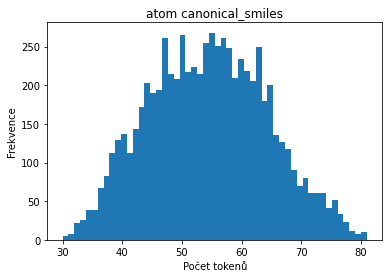


sln


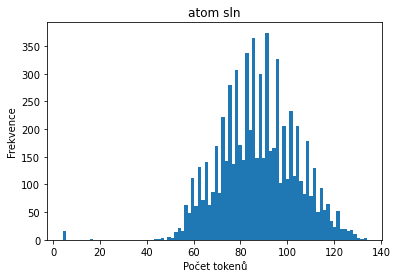


deep_smiles


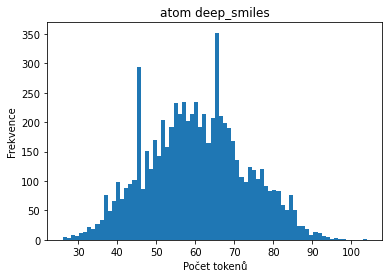


selfies


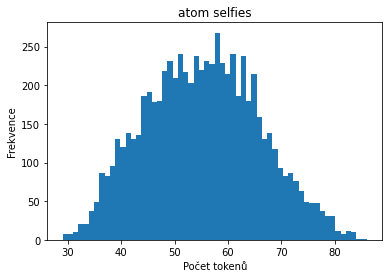


inchi


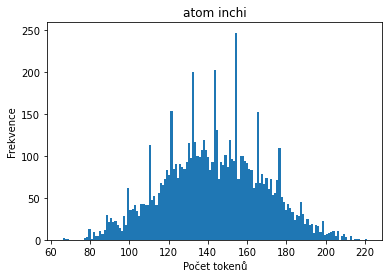

-----------------------------------------------------------------------------
bpe

canonical_smiles


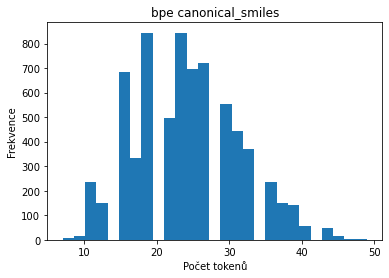


sln


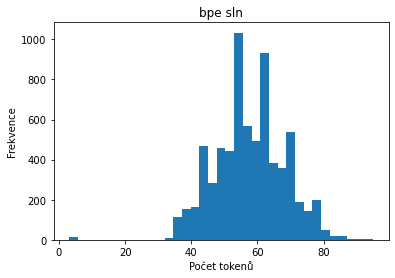


deep_smiles


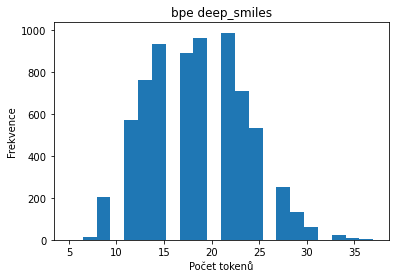


selfies


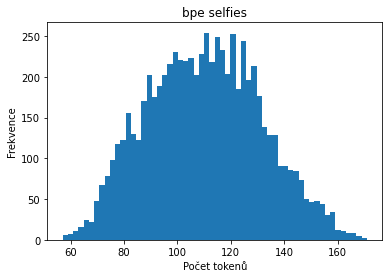


inchi


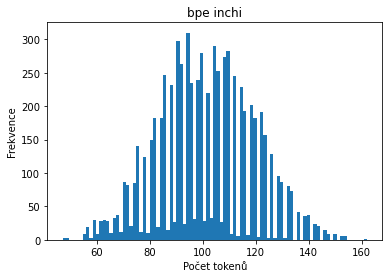

-----------------------------------------------------------------------------
char

canonical_smiles


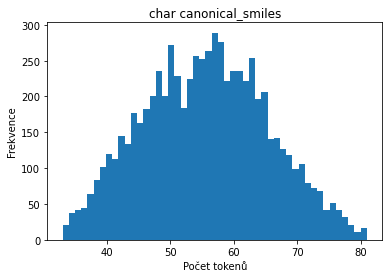


sln


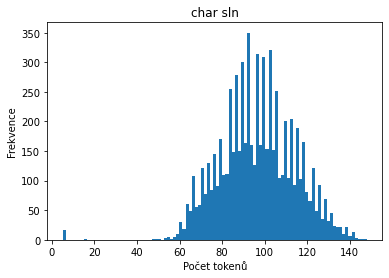


deep_smiles


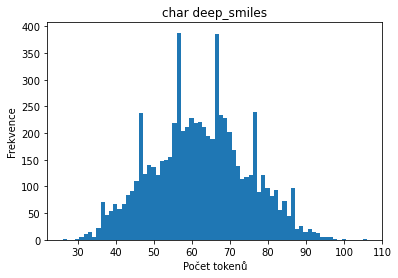


selfies


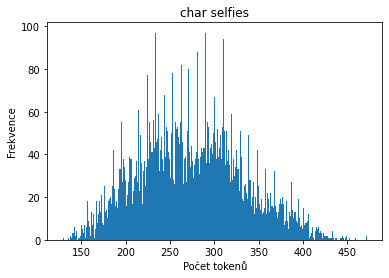


inchi


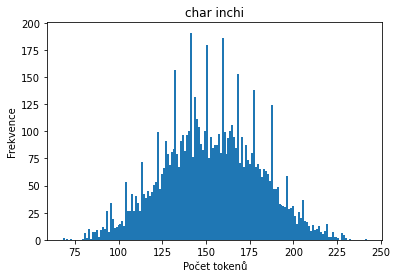

-----------------------------------------------------------------------------
spe

canonical_smiles


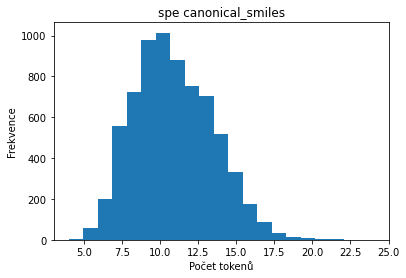


sln


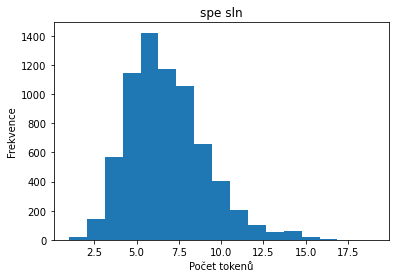


deep_smiles


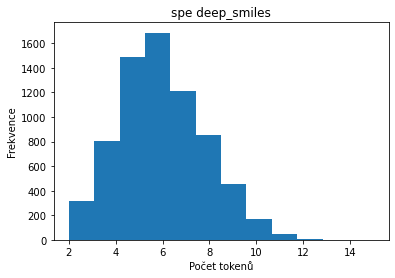


selfies


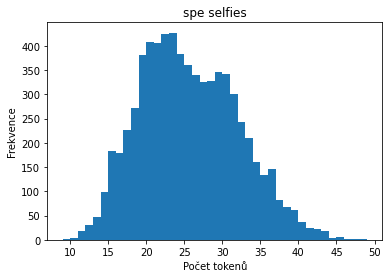


inchi


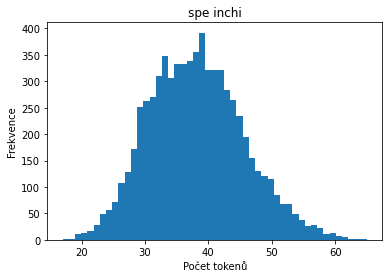

-----------------------------------------------------------------------------
kmer

canonical_smiles


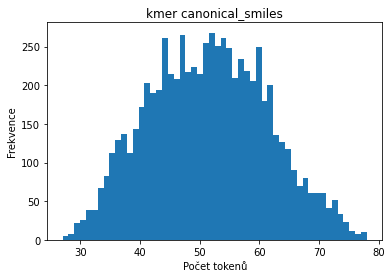


sln


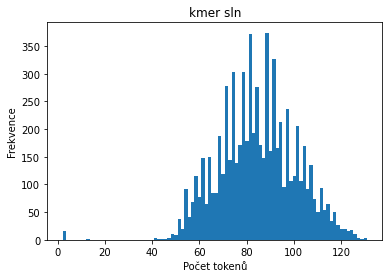


deep_smiles


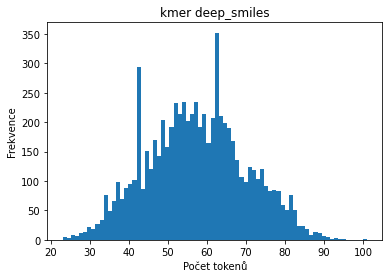


selfies


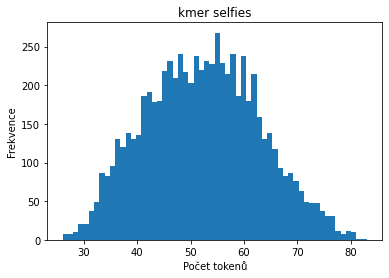


inchi


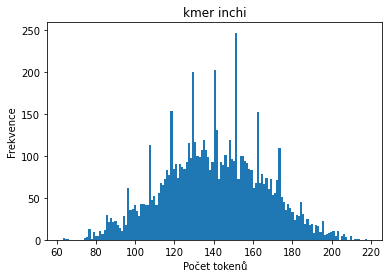

<Figure size 432x288 with 0 Axes>

In [28]:
# budu delat postupne po tokenizacich, abych to mohla kontrolovat
#DEFINIICE PROMENNYCH
tokenization_names = ['atom','bpe','char','spe','kmer']
linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']

n_patience = 1
RANDOM_STATE=42

print(dfClean.shape)

# ITERATE OVER TOKENIZATION
for i in range(len(tokenization_names)):
    tokenization = tokenization_names[i]
    print('-----------------------------------------------------------------------------\n'+tokenization)
    # ITERATE OVER LINEAR CHEMICAL NOTATION
    for j in range(len(linearNotation_names)):
        chem_notation = linearNotation_names[j]
        print('\n'+chem_notation)
        df_new = tokenize(dfClean.copy(),chem_notation,tokenization)
        plotHistogram(df_new[chem_notation+'_tokens_length'],chem_notation)

In [ ]:
# linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']

# for notName in linearNotation_names:
#     df[notName+'_length'] = df[notName].str.len()
#     plotHistogram(df[notName].str.len(),notName)